In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:


def load_data(base_path, data_path, pattern="params_best_epoch*.csv"):
    """
    Carga de forma recursiva todos los archivos CSV que coincidan con el patrón
    en el directorio formado por la combinación de base_path y data_path. 
    Además, extrae de la ruta del archivo metadatos útiles para el análisis:
      - version: Se extrae del antepenúltimo elemento de la ruta (por ejemplo, 'v1', 'v2', 'v3').
      - subfolder: El nombre del directorio donde se encuentra el archivo (por ejemplo, 'pooling_layers').
      - compression: Asignado automáticamente según el nombre del subfolder.
          * 'avg pooling' si subfolder es 'pooling_layers'.
          * 'strides' si subfolder está en ['convolutional_layers', 'kernel_strides', 'unet- convolutional-layers'].
          * 'unknown' en caso contrario.
      - file_source: El nombre del archivo leído.
      
    Args:
        base_path (str): Ruta base del proyecto (por ejemplo, '/home/guillermo/Documents/SINC/RNA/analysis/AEseq2seq/').
        data_path (str): Ruta relativa a la base donde se encuentran los datos 
                         (por ejemplo, 'notebooks/from_db/Unet/').
        pattern (str): Patrón de búsqueda de archivos. Por defecto "params_best_epoch*.csv".
        
    Returns:
        pd.DataFrame: DataFrame con todos los datos concatenados y las columnas adicionales:
                      'version', 'subfolder', 'compression', 'file_source'.
    """
    # Construir la ruta completa de los datos
    data_dir = os.path.join(base_path, data_path)
    file_pattern = os.path.join(data_dir, "**", pattern)
    csv_files = glob.glob(file_pattern, recursive=True)
    
    list_dfs = []
    if not csv_files:
        print("No se encontraron archivos con el patrón:", file_pattern)
    
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            # Extraer metadatos a partir de la ruta:
            # Se asume la siguiente estructura: BASE_PATH / DATA_PATH / version / subfolder / archivo.csv
            parts = file.split(os.sep)
            version = parts[-3] if len(parts) >= 3 else "unknown"
            subfolder = parts[-2] if len(parts) >= 2 else "unknown"
            
            # Determinar el método de compresión según el nombre del subfolder
            subfolder_lower = subfolder.lower()
            if subfolder_lower == "pooling_layers":
                compression = "avg pooling"
            elif subfolder_lower in ["convolutional_layers", "kernel_strides", "unet- convolutional-layers"]:
                compression = "strides"
            else:
                compression = "unknown"
            
            # Agregar las columnas de metadatos al DataFrame
            df["version"] = version
            df["subfolder"] = subfolder
            df["compression"] = compression
            df["file_source"] = os.path.basename(file)
            
            list_dfs.append(df)
        except Exception as e:
            print(f"Error al cargar el archivo {file}: {e}")
    
    if list_dfs:
        data = pd.concat(list_dfs, ignore_index=True)
    else:
        data = pd.DataFrame()
    
    return data

def filter_data(data, version=None, compression=None):
    """
    Filtra el DataFrame según la versión y/o el método de compresión.
    
    Args:
        data (pd.DataFrame): DataFrame que contiene la información cargada.
        version (str, opcional): Versión a filtrar (por ejemplo, 'v1', 'v2', 'v3').
                                 Si es None, no se filtra por versión.
        compression (str, opcional): Método de compresión a filtrar (por ejemplo, 'avg pooling' o 'strides').
                                     Si es None, no se filtra por este criterio.
    
    Returns:
        pd.DataFrame: DataFrame filtrado según los criterios indicados.
    """
    df_filtered = data.copy()
    if version is not None:
        df_filtered = df_filtered[df_filtered["version"] == version]
    if compression is not None:
        df_filtered = df_filtered[df_filtered["compression"] == compression]
    return df_filtered


In [3]:
BASE_PATH = '/home/guillermo/Documents/SINC/RNA/analysis/AEseq2seq/'
DATA_PATH = 'notebooks/from_db/Unet/'

# Cargar todos los datos que cumplan el patrón
data = load_data(BASE_PATH, DATA_PATH, pattern="params_best_epoch*.csv")
print("Datos cargados:", data.shape)


Datos cargados: (186, 31)


In [4]:
data.sample(10)

,run_uuid,name,best_epoch,arc_filters,arc_rank,arc_kernel,arc_stride_1,arc_stride_2,arc_num_conv1,arc_num_conv2,arc_skip_conn,hyp_lr,hyp_output_th,hyp_scheduler,best_epoch.1,train_loss,train_Accuracy,train_Accuracy_seq,train_F1,valid_loss,valid_Accuracy,valid_Accuracy_seq,valid_F1,test_loss,test_Accuracy,test_Accuracy_seq,test_F1,version,subfolder,compression,file_source
171,a192abf37c7d4da59201a189c40de13a,UNet-v2-avg-pooling-no-skips-num_convs-2-1,17,4,16,3,1,1,2,1,0,0.001,0.5,none,17,0.028864,0.976785,0.001582,0.976602,0.036543,0.964425,0.0,0.964197,0.037535,0.962992,0.0,0.962805,v2,pooling_layers,avg pooling,params_best_epoch.csv
48,0b795c61bbaa45f8abaaff1fa89f1009,UNet-num_convs-3-1-stride-1-1,18,4,8,3,1,1,3,1,1,0.001,0.5,none,18,0.000370,0.999996,0.997890,0.999996,0.000214,1.000000,1.0,1.000000,0.000221,1.000000,1.0,1.000000,v1,convolutional_layers,strides,params_best_epoch.csv
43,b8b78e51b04b4384b5641104ab78312c,UNet-num_convs-2-2-stride-2-2,19,4,8,3,2,2,2,2,1,0.001,0.5,none,19,0.093619,0.885614,0.000000,0.873570,0.089962,0.889449,0.0,0.876570,0.095846,0.880531,0.0,0.866565,v1,convolutional_layers,strides,params_best_epoch.csv
87,019e89457ade4e68b4c30d021a9e0e54,UNet-v3-no-skips-num_convs-1-2-latent-8,17,8,32,3,2,2,1,2,0,0.001,0.5,none,17,0.118591,0.842555,0.000000,0.810746,0.131445,0.824737,0.0,0.774071,0.127066,0.830954,0.0,0.797620,v3,convolutional_layers,strides,params_best_epoch.csv
127,236af9f0f3c64d7aa66d7e2659d49aa4,UNet-v3-num_convs-2-2-latent-8,19,16,64,3,2,2,2,2,1,0.001,0.5,none,19,0.000121,0.999995,0.997890,0.999995,0.000124,1.000000,1.0,1.000000,0.000128,1.000000,1.0,1.000000,v3,convolutional_layers,strides,params_best_epoch.csv
110,3317900eb4914510a59f04c76cd53cbf,UNet-v3-num_convs-1-1-latent-4,19,8,16,3,2,2,1,1,1,0.001,0.5,none,19,0.000101,0.999996,0.997890,0.999996,0.000103,1.000000,1.0,1.000000,0.000117,1.000000,1.0,1.000000,v3,convolutional_layers,strides,params_best_epoch.csv
105,cf3b355209e34af9b0964ebce3d5c0b6,UNet-v3-no-skips-num_convs-3-2-latent-4,18,32,128,3,2,2,3,2,0,0.001,0.5,none,18,0.089267,0.881327,0.000000,0.868749,0.115279,0.845962,0.0,0.819787,0.106705,0.854677,0.0,0.838389,v3,convolutional_layers,strides,params_best_epoch.csv
149,96b8c17449a04c52b1deb75feb1ca4da,UNet-v3-avg-pooling-num_convs-1-3,18,4,32,3,1,1,3,2,1,0.001,0.5,none,18,0.032585,0.970458,0.023734,0.970235,0.055618,0.930734,0.0,0.929824,0.054782,0.931523,0.0,0.930692,v3,pooling_layers,avg pooling,params_best_epoch.csv
114,27cbb3c8286f40fcac97cdfab5d01a2b,UNet-v3-num_convs-1-2-latent-32,19,8,32,3,2,2,1,2,1,0.001,0.5,none,19,0.000160,1.000000,1.000000,1.000000,0.000114,1.000000,1.0,1.000000,0.000129,1.000000,1.0,1.000000,v3,convolutional_layers,strides,params_best_epoch.csv
175,09d6ea077ccd416c9af2355a0fe602c0,UNet-v2-avg-pooling-no-skips-num_convs-3-2,19,4,32,3,1,1,3,2,0,0.001,0.5,none,19,0.081063,0.897427,0.000000,0.889296,0.114763,0.846460,0.0,0.821845,0.108573,0.856319,0.0,0.838109,v2,pooling_layers,avg pooling,params_best_epoch.csv


In [5]:
data.groupby(['version','compression']).size()

version  compression
v1       avg pooling    18
         strides        60
v2       avg pooling    18
         strides        12
v3       avg pooling    18
         strides        60
dtype: int64

In [8]:
data.query("version == 'v3' & compression == 'strides' & arc_skip_conn == 0")

,run_uuid,name,best_epoch,arc_filters,arc_rank,arc_kernel,arc_stride_1,arc_stride_2,arc_num_conv1,arc_num_conv2,arc_skip_conn,hyp_lr,hyp_output_th,hyp_scheduler,best_epoch.1,train_loss,train_Accuracy,train_Accuracy_seq,train_F1,valid_loss,valid_Accuracy,valid_Accuracy_seq,valid_F1,test_loss,test_Accuracy,test_Accuracy_seq,test_F1,version,subfolder,compression,file_source
78,a18b0494b01e4f15a955915ee29658d5,UNet-v3-no-skips-num_convs-1-1-latent-16,16,8,16,3,2,2,1,1,0,0.001,0.5,none,16,0.109207,0.857833,0.000000,0.837577,0.126235,0.833337,0.0,0.797072,0.123555,0.835542,0.0,0.805909,v3,convolutional_layers,strides,params_best_epoch.csv
79,0fd80ec63bd54ef388b28ca5ea21f306,UNet-v3-no-skips-num_convs-1-1-latent-32,19,8,16,3,2,2,1,1,0,0.001,0.5,none,19,0.094538,0.883243,0.000000,0.871734,0.120296,0.844906,0.0,0.819621,0.113974,0.850687,0.0,0.832052,v3,convolutional_layers,strides,params_best_epoch.csv
80,6344c74c74f641a595196691ee2d0044,UNet-v3-no-skips-num_convs-1-1-latent-4,19,8,16,3,2,2,1,1,0,0.001,0.5,none,19,0.117947,0.846862,0.000000,0.820486,0.130106,0.830616,0.0,0.787750,0.125416,0.837983,0.0,0.807612,v3,convolutional_layers,strides,params_best_epoch.csv
81,d900dc29439847078690fc149eb4e628,UNet-v3-no-skips-num_convs-1-1-latent-64,19,8,16,3,2,2,1,1,0,0.001,0.5,none,19,0.068566,0.923685,0.000000,0.919812,0.105099,0.869489,0.0,0.856669,0.099374,0.874773,0.0,0.864562,v3,convolutional_layers,strides,params_best_epoch.csv
82,3d05a4d4d3fd4ced8b394332ea15bc1c,UNet-v3-no-skips-num_convs-1-1-latent-8,19,8,16,3,2,2,1,1,0,0.001,0.5,none,19,0.117777,0.847037,0.000000,0.821221,0.130196,0.828743,0.0,0.783367,0.124233,0.835963,0.0,0.804480,v3,convolutional_layers,strides,params_best_epoch.csv
83,8151d5849b0146d6b5a773c3b54234d8,UNet-v3-no-skips-num_convs-1-2-latent-16,18,8,32,3,2,2,1,2,0,0.001,0.5,none,18,0.103448,0.867829,0.000000,0.851413,0.124874,0.837791,0.0,0.807496,0.120361,0.840189,0.0,0.817709,v3,convolutional_layers,strides,params_best_epoch.csv
84,182d14913075429f87f8375bd7154d50,UNet-v3-no-skips-num_convs-1-2-latent-32,17,8,32,3,2,2,1,2,0,0.001,0.5,none,17,0.083333,0.898654,0.000000,0.890957,0.113123,0.854751,0.0,0.833455,0.109075,0.857826,0.0,0.841981,v3,convolutional_layers,strides,params_best_epoch.csv
85,24c56b3f2e0240d68f4298ae2033e9ea,UNet-v3-no-skips-num_convs-1-2-latent-4,19,8,32,3,2,2,1,2,0,0.001,0.5,none,19,0.128030,0.829167,0.000000,0.791172,0.134740,0.820741,0.0,0.776141,0.132713,0.820658,0.0,0.786210,v3,convolutional_layers,strides,params_best_epoch.csv
86,79e1c590fa2c4eb2b1442e8311ba9a11,UNet-v3-no-skips-num_convs-1-2-latent-64,17,8,32,3,2,2,1,2,0,0.001,0.5,none,17,0.074009,0.914582,0.000000,0.909513,0.108397,0.862434,0.0,0.846976,0.102233,0.870774,0.0,0.859282,v3,convolutional_layers,strides,params_best_epoch.csv
87,019e89457ade4e68b4c30d021a9e0e54,UNet-v3-no-skips-num_convs-1-2-latent-8,17,8,32,3,2,2,1,2,0,0.001,0.5,none,17,0.118591,0.842555,0.000000,0.810746,0.131445,0.824737,0.0,0.774071,0.127066,0.830954,0.0,0.797620,v3,convolutional_layers,strides,params_best_epoch.csv


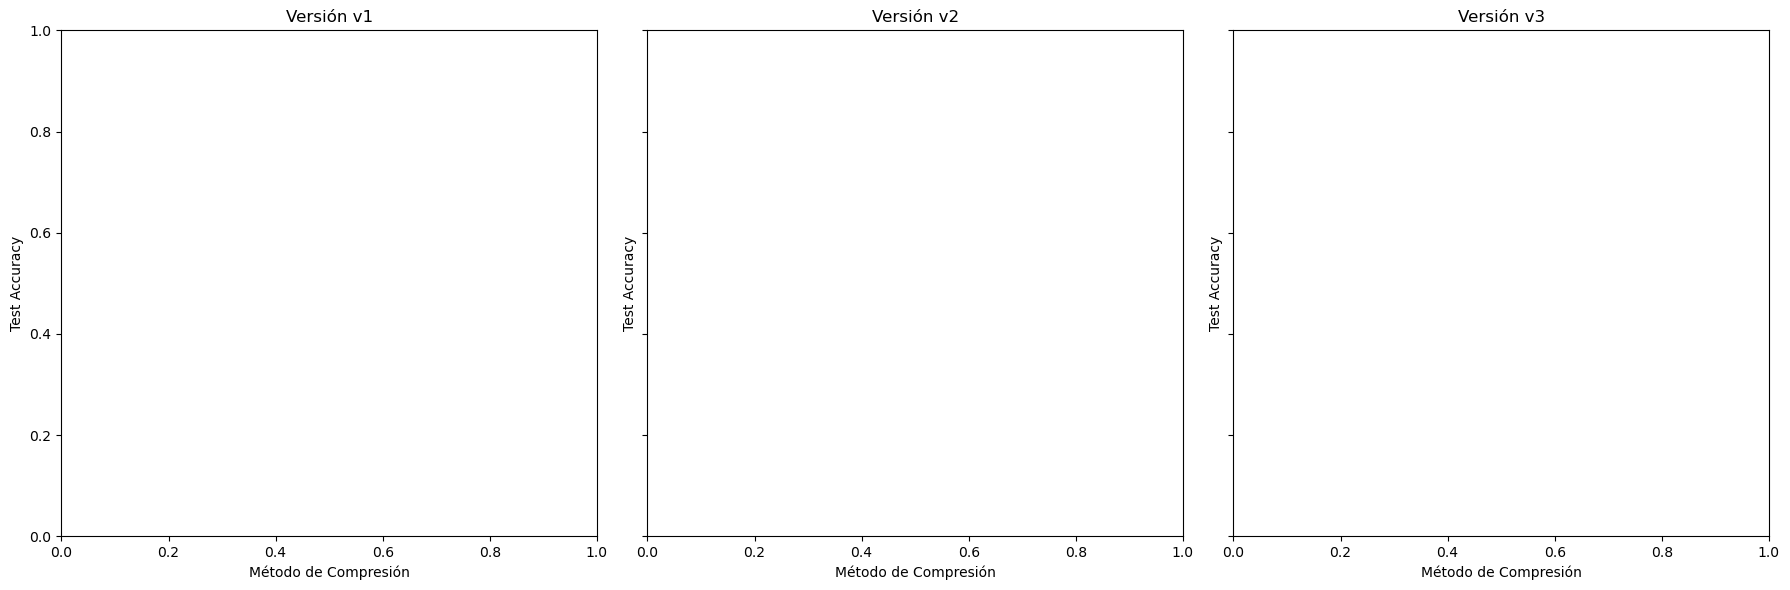

In [9]:
# Obtener las versiones únicas ordenadas
versions = sorted(data['version'].unique())
n_versions = len(versions)

# Crear subplots: una columna por versión
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(6 * n_versions, 6), sharey=True)

# Si solo hay una versión, axes no será una lista; lo forzamos a lista
if n_versions == 1:
    axes = [axes]

# Asignar cada gráfico a la subfigura correspondiente
for compression in sorted(data['compression'].unique()):
    for ax, version in zip(axes, versions):
        subset = data[(data['version'] == version) & data['compression'] == compression ]
        sns.scatterplot(data=subset, x="arc_num_conv1", y="test_Accuracy", hue="arc_num_conv2", ax=ax)
        ax.set_title(f"Versión {version}")
        ax.set_xlabel("Método de Compresión")
        ax.set_ylabel("Test Accuracy")
        # Mover la leyenda fuera de la subfigura
        # ax.legend(title="cc", bbox_to_anchor=(1, 1), loc="upper left")
    
plt.tight_layout()
plt.show()


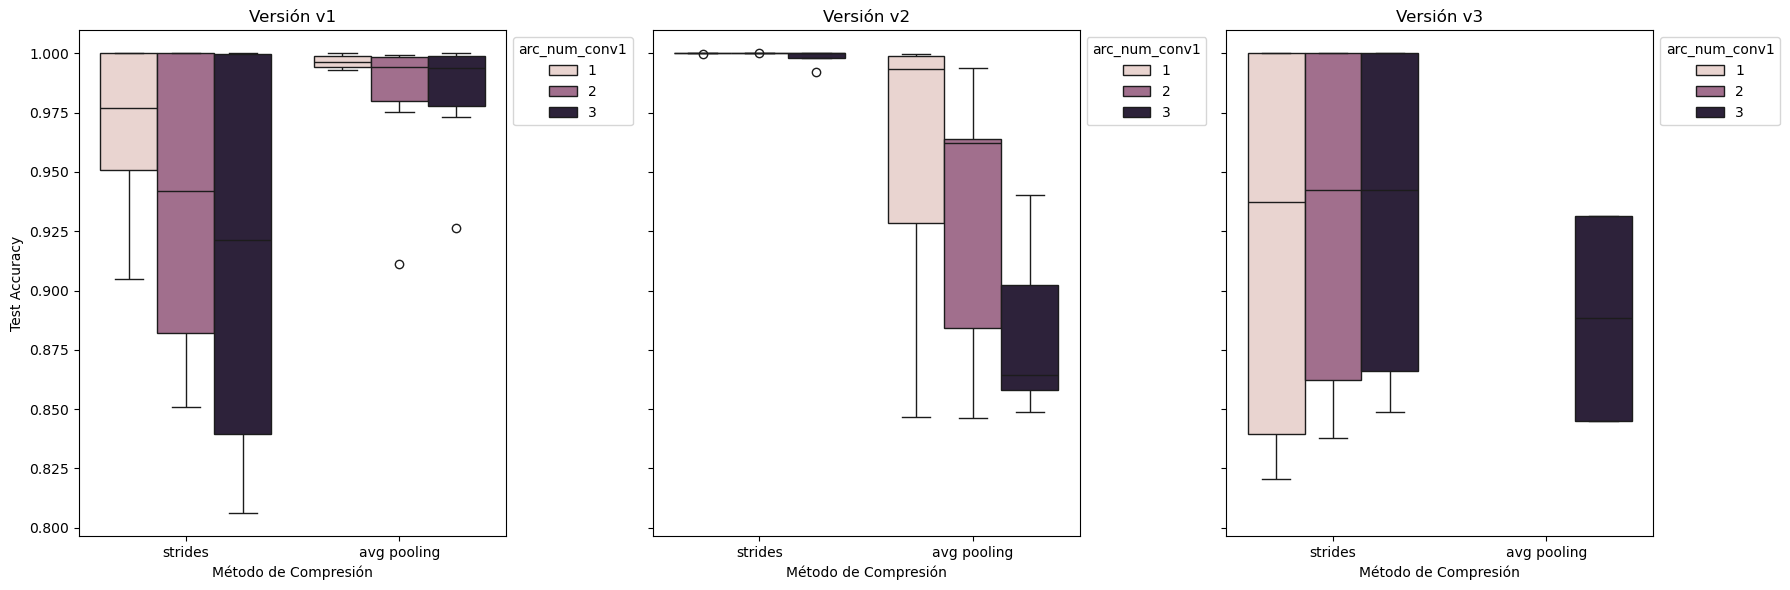

In [10]:
# Obtener las versiones únicas ordenadas
versions = sorted(data['version'].unique())
n_versions = len(versions)

# Crear subplots: una columna por versión
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(6 * n_versions, 6), sharey=True)

# Si solo hay una versión, axes no será una lista; lo forzamos a lista
if n_versions == 1:
    axes = [axes]

# Asignar cada gráfico a la subfigura correspondiente
for ax, version in zip(axes, versions):
    subset = data[data['version'] == version]
    sns.boxplot(data=subset, x="compression", y="test_Accuracy", hue="arc_num_conv1", ax=ax)
    ax.set_title(f"Versión {version}")
    ax.set_xlabel("Método de Compresión")
    ax.set_ylabel("Test Accuracy")
    # Mover la leyenda fuera de la subfigura
    ax.legend(title="arc_num_conv1", bbox_to_anchor=(1, 1), loc="upper left")
    
plt.tight_layout()
plt.show()


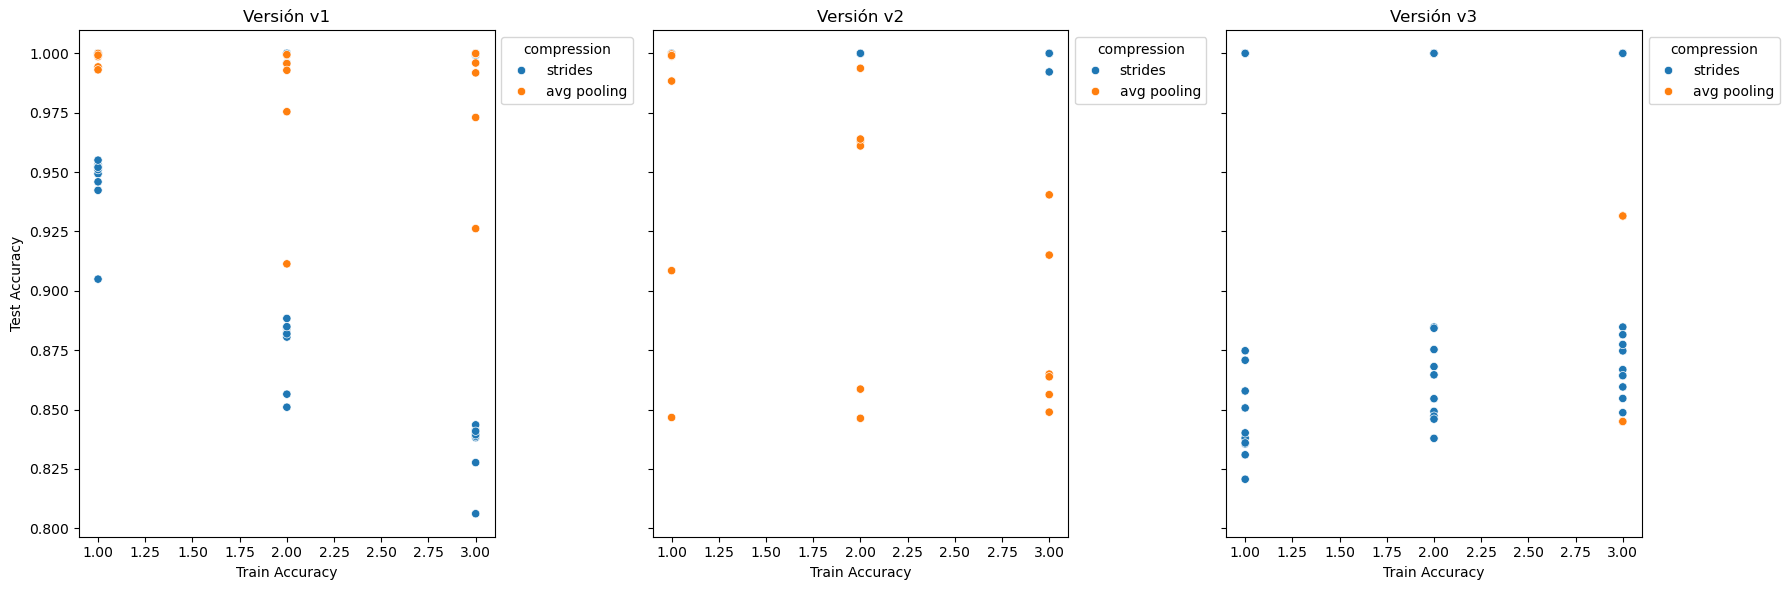

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(6 * n_versions, 6), sharex=True, sharey=True)

if n_versions == 1:
    axes = [axes]

for ax, version in zip(axes, versions):
    subset = data[data['version'] == version]
    sns.scatterplot(data=subset, x="arc_num_conv1", y="test_Accuracy", hue="compression", ax=ax)
    ax.set_title(f"Versión {version}")
    ax.set_xlabel("Train Accuracy")
    ax.set_ylabel("Test Accuracy")
    ax.legend(title="compression", bbox_to_anchor=(1, 1), loc="upper left")
    
plt.tight_layout()
plt.show()


/tmp/ipykernel_472804/3984020778.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subset, x="compression", y="test_Accuracy", ci="sd", ax=ax)
/tmp/ipykernel_472804/3984020778.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subset, x="compression", y="test_Accuracy", ci="sd", ax=ax)
/tmp/ipykernel_472804/3984020778.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subset, x="compression", y="test_Accuracy", ci="sd", ax=ax)


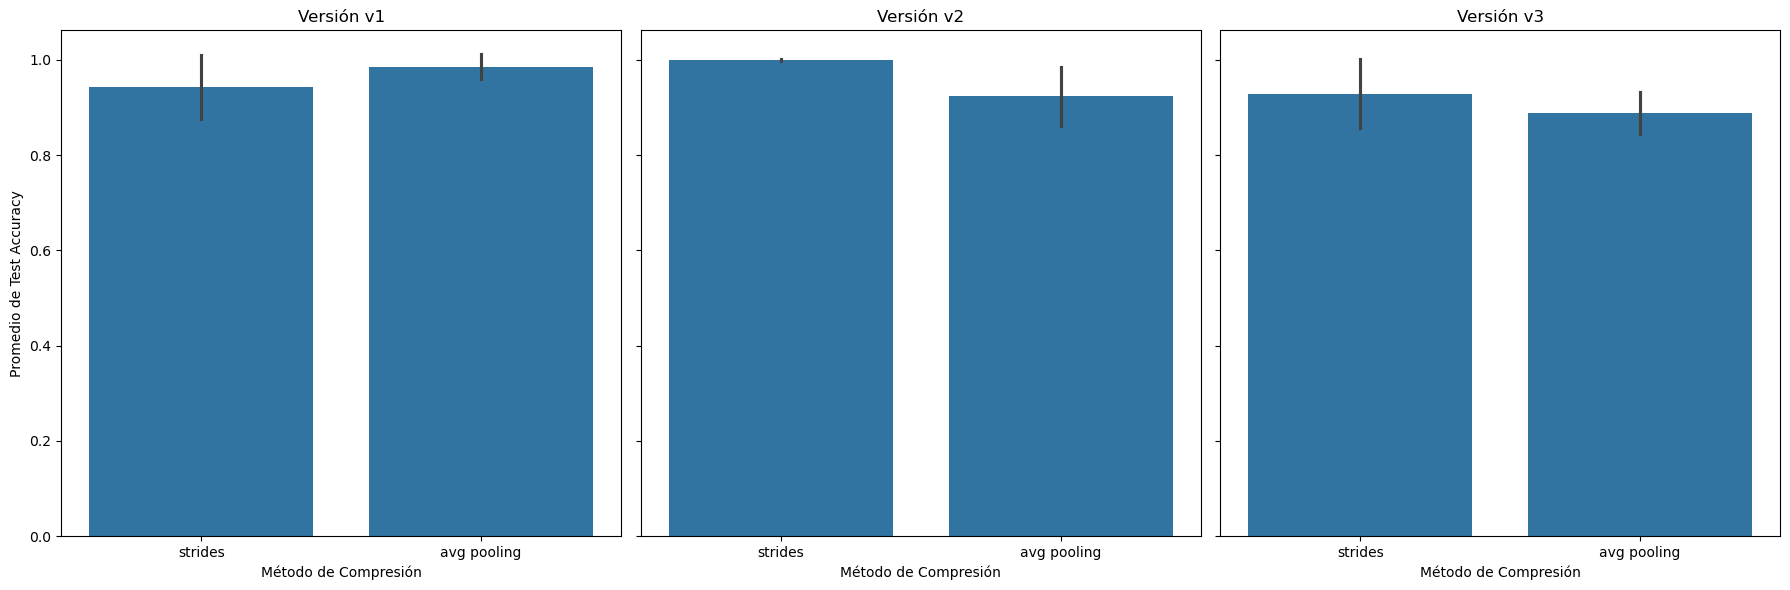

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(6 * n_versions, 6), sharey=True)

if n_versions == 1:
    axes = [axes]

for ax, version in zip(axes, versions):
    subset = data[data['version'] == version]
    sns.barplot(data=subset, x="compression", y="test_Accuracy", ci="sd", ax=ax)
    ax.set_title(f"Versión {version}")
    ax.set_xlabel("Método de Compresión")
    ax.set_ylabel("Promedio de Test Accuracy")
    
plt.tight_layout()
plt.show()
